# Imports

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os
import pywt

/home/amirhossein/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
from IPython.display import clear_output

# Getting csv files

In [3]:
# Geting csv files
list_of_files = os.listdir("./")
csv_files = []

for _file in list_of_files:
    if _file.endswith(".csv"):
        csv_files.append(_file)

csv_files

['5_When_rebuilding.csv',
 '1_After_reconstruction.csv',
 '1_When_rebuilding.csv',
 '2_Before_renovation.csv',
 '6_After_reconstruction.csv',
 '2_When_rebuilding.csv',
 '4_Before_renovation.csv',
 '5_After_reconstruction.csv',
 '3_When_rebuilding.csv',
 '3_After_reconstruction.csv',
 '6_Before_renovation.csv',
 '4_After_reconstruction.csv',
 '1_Before_renovation.csv',
 '3_Before_renovation.csv',
 '6_When_rebuilding.csv',
 '2_After_reconstruction.csv',
 '5_Before_renovation.csv',
 '4_When_rebuilding.csv']

# Functions

In [4]:
def custom_slicer(signal, fs=825.8):
    '''
    Returns: first 10 seconds
             last 30 seconds of the signal
    '''

    return signal[:int(fs * 10)], signal[int(-30 * fs):]

In [5]:
def slicer(signal, fs=825.8, chunk_size_seconds=10):
    '''
    Returns: sliced signal in desired seconds chunks
    Note: size of the signal should be a true nominator of chunk size
    '''
    chunk_size = int(fs * chunk_size_seconds)
    return [signal[_ * chunk_size : (_+1)*chunk_size ] for _ in range(int(len(signal)/chunk_size))]

In [14]:
def signal_to_heatmap(coefficients, frequencies):
    '''
    Returns the heatmap of signal
    '''
    power = (abs(coefficients)) ** 2
    period = 1. / frequencies
    
    # Setting contourlevels automatically in "10" different color range
    max_power = np.log2(power.max())
    min_power = np.log2(power.min())
    contourlevels = np.linspace(np.log2(min_power), np.log2(max_power), num=10)

    fs = 825.8
     
    # Generate a time array based on the length of the signal or coefficients
    time = np.linspace(0, len(coefficients[0]) / fs, num=len(coefficients[0]))
    cmap = plt.cm.seismic

    # Desired size in pixels
    width_px = 600
    height_px = 600

    # DPI (dots per inch)
    dpi = 300

    # Convert to inches
    width_in = width_px / dpi
    height_in = height_px / dpi
    
    # Set the size of the heatmap
    fig, ax = plt.subplots(figsize=(width_in, height_in), dpi=dpi)
    im = ax.contourf(time, np.log2(period), np.log2(power), contourlevels, extend='both',cmap=cmap)
    
    yticks = 2**np.arange(np.ceil(np.log2(period.min())), np.ceil(np.log2(period.max())))
    ax.set_yticks(np.log2(yticks))
    ax.set_yticklabels(yticks)
    ax.invert_yaxis()
    ylim = ax.get_ylim()
    ax.set_ylim(ylim[0], -1)

In [8]:
def dir_creator(csv_file_name):
    '''
    Creating directoies for each column of csv files
        to save heatmaps into them
    '''
    file_name = csv_file_name.split('.')[0]
    os.mkdir(file_name)
    os.mkdir(f"{file_name}/train_out")
    os.mkdir(f"{file_name}/train_in")

In [10]:
def save_heatmap(csv_file_name, column, counter, train_status):
    '''
    Saving plots in png format in their specific path
    '''
    path = f"{csv_file_name.split('.')[0]}/{train_status}/{csv_file_name}_{column}_{counter}.png"
    plt.savefig(path , dpi=300, bbox_inches='tight')

In [11]:
def remove_five_zeros(arr):
    """Remove sequences of 5 successive zeros from an array."""
    result = []
    zero_count = 0

    for i in range(len(arr)):
        if arr[i] == 0:
            zero_count += 1
        else:
            if zero_count == 5:
                result = result[:-5]  # Remove the last 5 zeros from the result
            zero_count = 0
            result.append(arr[i])
        
        # If we've reached the end and have exactly 5 zeros at the end
        if i == len(arr) - 1 and zero_count == 5:
            result = result[:-5]
    
    return np.array(result)

In [10]:
def continuous_wavelet_transform(signal, fs, min_freq, max_freq, wavelet_name='morl'):
    """
    Perform Continuous Wavelet Transform on a given signal with specified frequency range.
    return: (coefficients, frequencies) tuple
             - coefficients: 2D array of CWT coefficients
             - frequencies: Corresponding frequencies for the scales
    """
    # Center frequency of the Morlet wavelet
    center_freq = pywt.central_frequency(wavelet_name)
    
    # Calculate scales based on desired frequency range
    min_scale = center_freq * fs / max_freq
    max_scale = center_freq * fs / min_freq
    scales = np.arange(min_scale, max_scale)
    
    # Perform the Continuous Wavelet Transform
    coefficients, frequencies = pywt.cwt(signal, scales, wavelet_name, sampling_period=1/fs)
    
    return coefficients, frequencies

# Setting min and max frequency

In [11]:
# Initializing fs
fs=825.8

In [22]:
# Reading files
df = pd.read_csv("./1_After_reconstruction.csv")

# Nan to zero
df = df.fillna(0)
    
# Loading each column of df into dict
columns_dict = {}
for col in df.columns:
    columns_dict[col] = df[col].to_numpy()
# Removing first incremental column
columns_dict.pop('Unnamed: 0')

# Removing 5 successive zeros
signal = remove_five_zeros(columns_dict['201'])

In [23]:
# Perform Fourier Transform to analyze frequency content
frequencies = np.fft.fftfreq(len(signal), d=1/fs)
fft_magnitude = np.abs(np.fft.fft(signal))

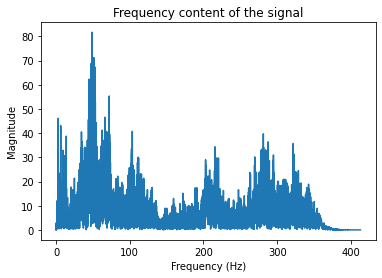

In [24]:
# Plot the Fourier Transform
plt.figure()
plt.plot(frequencies[:len(frequencies)//2], fft_magnitude[:len(frequencies)//2])
plt.title("Frequency content of the signal")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.show()

In [12]:
min_freq = 1
max_freq = 400

# Creating heatmaps of CWT signals

In [13]:
wavelet_name='cmor'

Processing: 5_When_rebuilding.csv:	 Column 0
		. Removing 5 successive zeros
		. Calculating CWT transform and heatmap creation


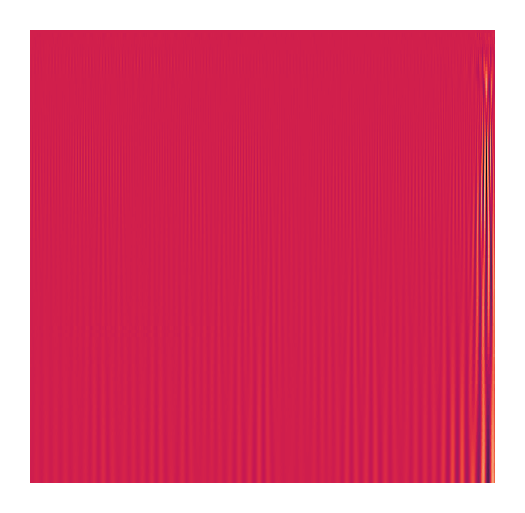

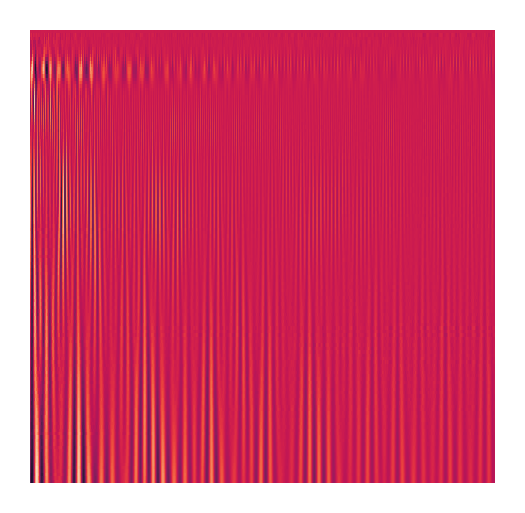

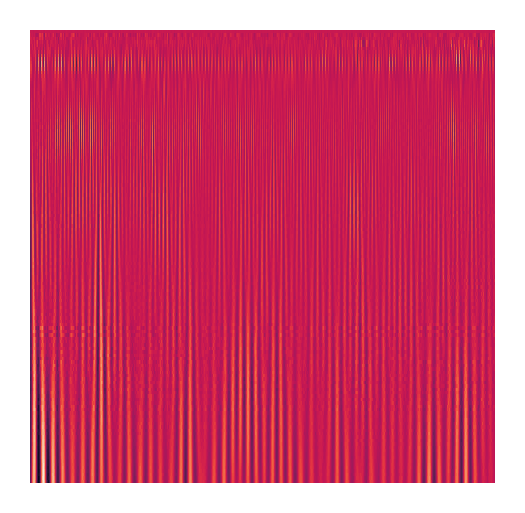

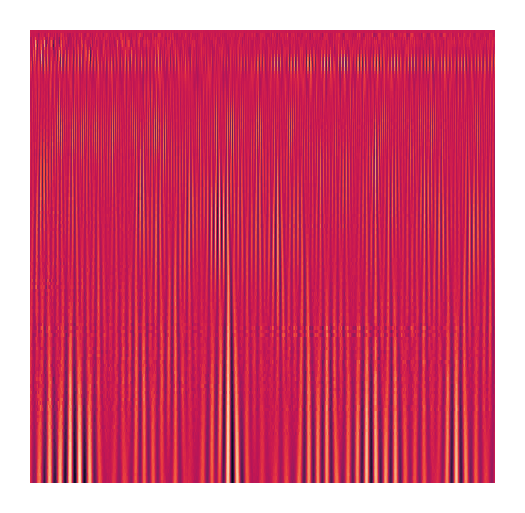

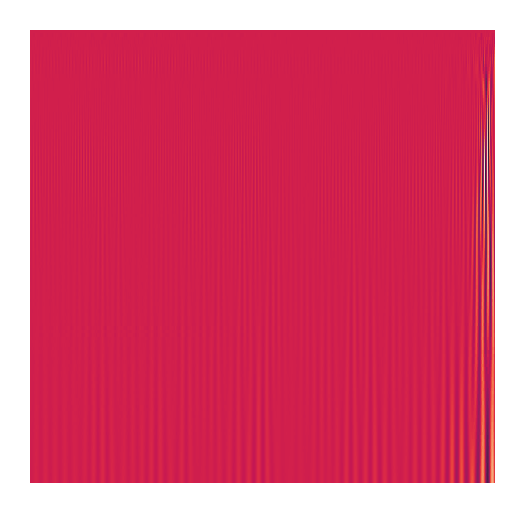

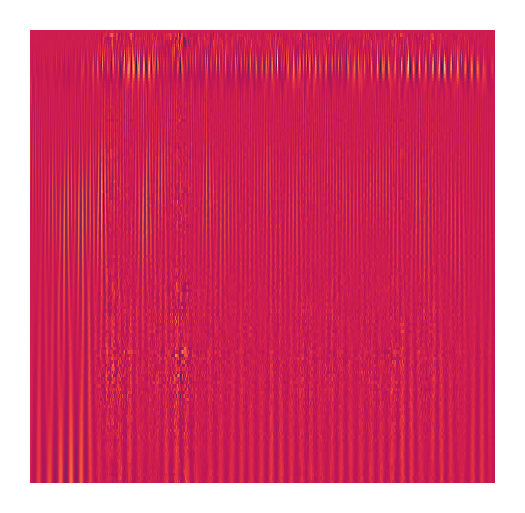

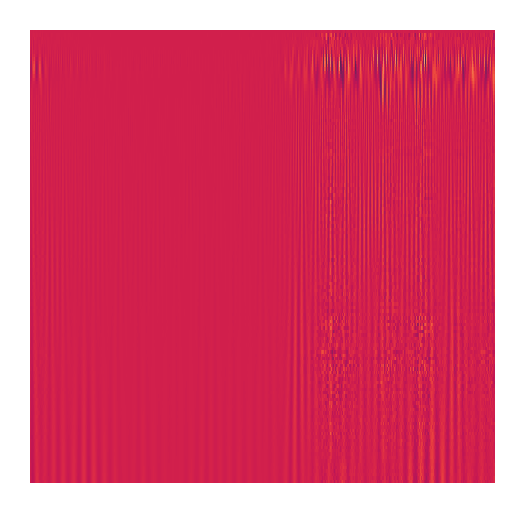

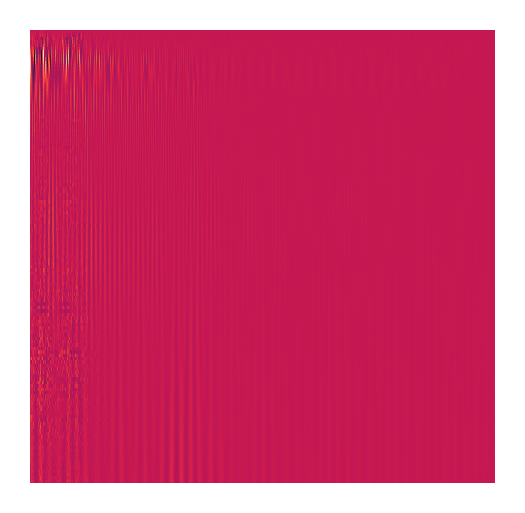

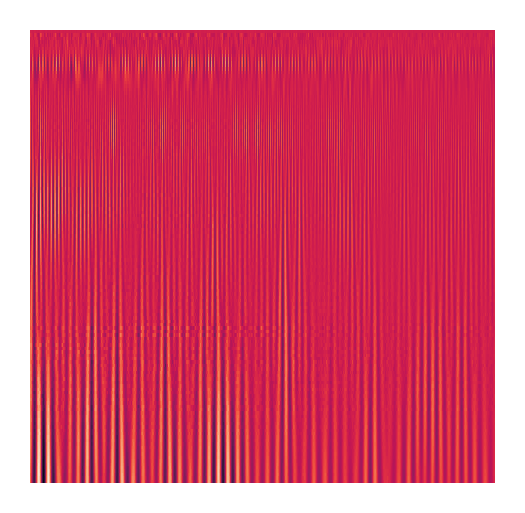

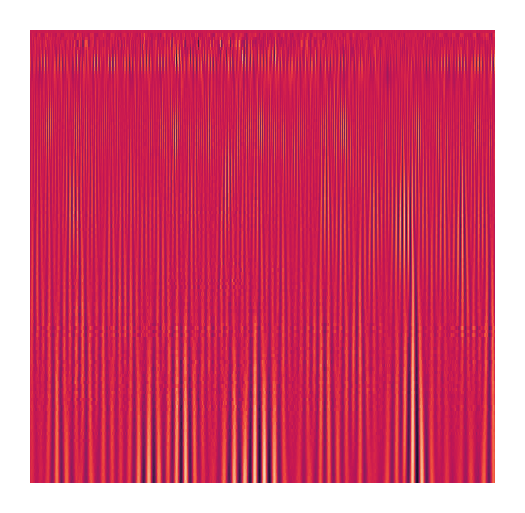

In [36]:
# Reading and processing csv files
for csv_file in csv_files:
    # Reading files
    df = pd.read_csv(csv_file)

    # Nan to zero
    df = df.fillna(0)
    
    # Loading each column of df into dict
    columns_dict = {}
    for col in df.columns:
        columns_dict[col] = df[col].to_numpy()
    # Removing first incremental column
    columns_dict.pop('Unnamed: 0') 

    # Creating dirs
    dir_creator(csv_file, len(columns_dict.keys()))

    heatmaps_counter = 1

    for col in columns_dict.keys():
        clear_output(wait=True)

        print(f"Processing: {csv_file}:\t Column {col}")

        # Removing 5 successive zeros
        print("\t\t. ", end="")
        print("Removing 5 successive zeros")
        columns_dict[col] = remove_five_zeros(columns_dict[col])

        # handling train out part
        first_10, last_30 = custom_slicer(columns_dict[col], fs)
        last_30_signals_chunked = slicer(last_30)
        
        # Calculating CWT transform and heatmap creation
        print("\t\t. ", end="")
        print("Calculating CWT transform and heatmap creation")
        coefficients, frequencies = continuous_wavelet_transform(first_10, fs, min_freq, max_freq, wavelet_name)
        signal_to_heatmap(coefficients, frequencies)
        save_heatmap(csv_file, col, heatmaps_counter, "train_out")
        heatmaps_counter += 1
        
        for sig_chunk in last_30_signals_chunked:
            coefficients, frequencies = continuous_wavelet_transform(sig_chunk, fs, min_freq, max_freq, wavelet_name)
            signal_to_heatmap(coefficients, frequencies)
            save_heatmap(csv_file, col, heatmaps_counter, "train_out")
            heatmaps_counter += 1
        
        # handling train in part
        train_in_sig_chunks = slicer(columns_dict[col][10*fs:-30*fs])
        for sig_chunk in train_in_sig_chunks:
            coefficients, frequencies = continuous_wavelet_transform(sig_chunk, fs, min_freq, max_freq, wavelet_name)
            signal_to_heatmap(coefficients, frequencies)
            save_heatmap(csv_file, col, heatmaps_counter, "train_in")
            heatmaps_counter += 1